# Data Normalization Mini Class

In [2]:
import os

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

from data_norm_class.constants import (
    FILE_DATA_RAW,
    FOLDER_DATA_NORMALIZED,
    FOLDER_DB
)
from data_norm_class.io import (
    read_raw_aarc_data
)
from data_norm_class.normalization import (
    normalize_data
)

In [3]:
FOLDER_DATA_NORMALIZED = os.path.join("..", FOLDER_DATA_NORMALIZED)
FILE_DATA_RAW = os.path.join("..", FILE_DATA_RAW)
FOLDER_DB = os.path.join("..", FOLDER_DB)

## What's wrong with single CSV files?

- CSV files are a great way to store your tabular data without much memory overhead
- The tabular structure is flexible and CSVs are accessible across domains and tools
- It's a great way to store data in which each row is a unique **entity**
- If this uniqueness is violated, things easily become messy

Let's use a random subset of 40 departments of the `AARC-v3` dataset as our sample.

In [4]:
aarc_sample_raw = read_raw_aarc_data(FILE_DATA_RAW)
aarc_sample_raw.head()

,PersonId,PersonName,Gender,DepartmentId,DepartmentName,InstitutionId,InstitutionName,Year,Rank,DegreeYear,DegreeInstitutionId,DegreeInstitutionName,PrimaryAppointment,Taxonomy,Field,Area,Umbrella,Academia
0,16120,<hidden>,Female,10918,"Biostatistics and Epidemiology, Department of",324,University of Oklahoma,2016,Associate Professor,1997,324,University of Oklahoma,True,Biostatistics,Biostatistics,Biological Sciences,Natural Sciences,Academia
1,16120,<hidden>,Female,10918,"Biostatistics and Epidemiology, Department of",324,University of Oklahoma,2016,Associate Professor,1997,324,University of Oklahoma,True,Epidemiology,Epidemiology,Medical Sciences,Medicine and Health,Academia
2,16120,<hidden>,Female,10918,"Biostatistics and Epidemiology, Department of",324,University of Oklahoma,2017,Associate Professor,1997,324,University of Oklahoma,True,Biostatistics,Biostatistics,Biological Sciences,Natural Sciences,Academia
3,16120,<hidden>,Female,10918,"Biostatistics and Epidemiology, Department of",324,University of Oklahoma,2017,Associate Professor,1997,324,University of Oklahoma,True,Epidemiology,Epidemiology,Medical Sciences,Medicine and Health,Academia
4,33345,<hidden>,Male,9514,"Microbiology and Physiological Systems, Depart...",292,University of Massachusetts Medical School,2018,Professor,1986,110,Louisiana State University Health Sciences Cen...,True,Molecular Genetics,<NA>,Medical Sciences,Medicine and Health,Academia


On a first glance, the file structure might suggest that each row stands for a faculty (identified by `PersonId`) being hired at a department (`DepartmentId`) in a given year (`Year`) with additional metadata.

Let's check this assumption by comparing the number of unique rows for these triplets.

In [5]:
print((
    "Number of unique PersonId, Year, and DepartmentId combinations: "
    f"{aarc_sample_raw[['PersonId', 'Year', 'DepartmentId']].drop_duplicates().shape[0]}\n"
    f"Number of rows in the raw data: {aarc_sample_raw.shape[0]}"))


Number of unique PersonId, Year, and DepartmentId combinations: 8298
Number of rows in the raw data: 12292


There is a mismatch of roughly 4,000 rows, because the dataset contains the full combination of multiple **entities** and all of their **relationships**, beyond `(PersonId, DepartmentId, Year)`.

### Redundancy
- Much of the information is **redundant** across rows
  - for instance, consider the `DepartmentName` column

In [6]:
aarc_sample_raw["DepartmentName"].nunique()

34

This column stores only 34 different values because it only holds a single information per department.
However, these values are repeated across all 12k rows, which is very memory-inefficient.

In [7]:
print(("Memory usage of the 'DepartmentName' column: "
       f"{aarc_sample_raw['DepartmentName'].memory_usage(index=False, deep=True) / 1024**2:.2f} MB"))

Memory usage of the 'DepartmentName' column: 1.12 MB


Recall that this is just a small sample of the full data. 
The entire original dataset contains ~916MB of data which can quickly increase when performing join-operations.
Normalizing the data will improve this by assigning `DepartmentName`s only to the entity that it's relevant for (departments) and isolating this relationship from others in separate tables.

Redundancy also entails repeated relationships.
As we've seen before, each row holds a combination of all possible relationships between the columns `(DepartmentId, PersonId, Year, Taxonomy)`.
This way, all `(DepartmentId, PersonId, Year)` hirings are repeated multiple times if a department is assigned to multiple umbrellas. 
This is not only inefficient, but prone to errors when aggregating data based on these attributes.

Another problem with redundant data are the costs of alteration.
Updates always affect all entries in our entire dataset.
If updates are common, e.g., in databases storing users, this can quickly become a bottleneck, slowing down other operations.
Adding other relationships, e.g., publication data, requires joining the entire data.
In this example, each `(PersonId, Year)` item would be linked to all its publications.
Because `(PersonId, Year)` is already redundant, this would greatly increase the dataset size.


### Integrity

- **entity integrity** ensures that entities are identifiable
  - they must have a **primary key**: a unique identifier differentiating them from each other
  - no two entities should have the same primary key and it should not be missing
  - the `AARCv3` data already has these identifiers for faculty (`PersonId`), departments (`DepartmentId`) and institutions (`InstitutionId`)
    - this makes it possible to differentiate between entities with similar attributes, e.g., people of the same name

In [8]:
aarc_sample_raw[["PersonId", "DepartmentId", "InstitutionId"]]\
    .nunique()

PersonId         1317
DepartmentId       40
InstitutionId      37
dtype: int64

- however, there are no explicit identifiers for relationships
- **foreign integrity** ensures that relationships link to valid entities
  - for this purpose, a **foreign key** maps between items in one table to existing entities in another table
    - for instance, if we had a table of publication records with `PersonId` as a foreign key, these should point to a single, valid faculty member
- making relationships identifiable allows us to easily extend the data by assigning metadata
  - for instance, assigning faculty `Rank` to their hiring at a given year  
- we will need to ensure this integrity when splitting our dataset into  multiple tables in the normalization process

## Data normalization
- data normalization ensures non-redundancy and integrity in entities and relations
- by isolating entities from their relations, it improves 
  - expressiveness
  - size requirements
  - extendibility
- various **normal forms** pose increasing demands
- typically, a dataset is consider normalized, if it follows the third normal form **3NF**

### 3. Normal Form (3NF)

3NF requires that 
1. each cell only stores an atomic value (no lists or other collections like `json`)
2. all non-key columns (or **attributes**) depend on the entire primary key, not just parts of it
3. there are no transitive relationships in which one attribute depends on another 

Let's have a look at the columns of `AARC-v3`.

In [9]:
aarc_sample_raw.columns

Index(['PersonId', 'PersonName', 'Gender', 'DepartmentId', 'DepartmentName',
       'InstitutionId', 'InstitutionName', 'Year', 'Rank', 'DegreeYear',
       'DegreeInstitutionId', 'DegreeInstitutionName', 'PrimaryAppointment',
       'Taxonomy', 'Field', 'Area', 'Umbrella', 'Academia'],
      dtype='object')

#### 3NF violations of AARC-v3

- `AARC-v3` does not violate the first requirement (all columns contain atomic values only)
- the **primary key** of this table is a **compound key** of 
  - `PersonId`
  - `DepartmentId`
  - `Year`
  - `Umbrella`
  

In [10]:
aarc_sample_raw\
    [["PersonId", "DepartmentId", "Year", "Taxonomy"]]\
    .drop_duplicates()\
    .shape

(12292, 4)

In [11]:
aarc_sample_raw.shape

(12292, 18)

- violations of the second and third requirements include
  - (2.) `PersonName` depending only on `PersonId`
  - (2.) `Rank` depending only on `(DepartmentId, PersonId, Year)`
  - (3.) `InstitutionName` depending on `InstitutionId` which depends on `DepartmentId` only (2.)
- see [appendix](#other-normal-forms) for details on other normal forms
  - in any real setting you typically go straight to 3NF 
  - but how?

### Entity-Relationship diagram
- first, map out the **entities** and **relationships** in your data in an **Entity-Relation diagram** ([ERD](https://en.wikipedia.org/wiki/Entity%E2%80%93relationship_model))

```mermaid
erDiagram
    persons {
        int PersonId PK
        int DegreeInstitutionId FK
        string PersonName
        int DegreeYear
        string Gender
    }

    institutions {
        int InstitutionId PK
        string InstitutionName
    }

    departments {
        int DepartmentId PK
        string DepartmentName
    }

    taxonomies {
        int TaxonomyId PK
        string Taxonomy
    }

    fields {
        int FieldId PK
        string Field
    }

    areas {
        int AreaId PK
        string Area
    }

    umbrellas {
        int UmbrellaId PK
        string Umbrella
    }

    department_taxonomy {
        int DepartmentId PK, FK
        int TaxonomyId PK, FK
        int AreaId FK
        int FieldId FK
        int UmbrellaId FK
    }

    appointments {
        int PersonId PK, FK 
        int InstitutionId PK, FK 
        int DepartmentId PK, FK
        int Year PK 
        string Rank
        boolean PrimaryAppointment
        boolean Imputed
    }

    persons }o--o| institutions : "degree_from"

    appointments }|--|| persons : "has_appointment"
    appointments }o..o| institutions : "at_institution"
    appointments }|--|| departments : "in_department"

    department_taxonomy }o--|{ departments : "maps_department"
    department_taxonomy }o--|{ taxonomies : "maps_taxonomy"
    department_taxonomy }o--o{ fields : "maps_field"
    department_taxonomy }o--o{ areas : "maps_area"
    department_taxonomy }o--o{ umbrellas : "maps_umbrella"
```

### Transforming AARC to 3NF
The `normalize_data` function implements the transformation from the unnormalized table to a collection of tables.
It returns a custom `AARCCollection` object that stores the tables as members.

In [12]:
aarc_nf = normalize_data(aarc_sample_raw)

	Faculty count: 1317
	Departments count: 40
	Institutions count: 37
	Taxonomy count: 41
	Umbrella count: 8
	Area count: 19
	Field count: 34
	Department x Taxonomy x Field x Area x Umbrella count: 53


In [13]:
aarc_nf.appointments

Rank  \
PersonId Year DepartmentId InstitutionId                        
1142     2011 12089        347            Assistant Professor   
         2012 12089        347            Associate Professor   
         2013 12089        347            Associate Professor   
         2014 12089        347            Associate Professor   
         2015 12089        347            Associate Professor   
...                                                       ...   
1982644  2023 5838         204            Assistant Professor   
1982686  2023 5838         204            Associate Professor   
1982687  2023 5838         204            Associate Professor   
1982688  2023 5838         204            Associate Professor   
1982689  2023 5838         204            Associate Professor   

                                          PrimaryAppointment  
PersonId Year DepartmentId InstitutionId                      
1142     2011 12089        347                          True  
         2012 12089        347                          True  
         2013 12089        347                          True  
         2014 12089        347                          True  
         2015 12089        347                          True  
...                                                      ...  
1982644  2023 5838         204                          True  
1982686  2023 5838         204                          True  
1982687  2023 5838         204                          True  
1982688  2023 5838         204                          True  
1982689  2023 5838         204                          True  

[8298 rows x 2 columns]

To create entity tables, we simply aggregate the respective attributes by the respective primary key:

```python
    df_persons = df_data.groupby("PersonId")\
        .aggregate({
            "Gender": "first",
            "DegreeYear": "first",
            "PersonName": "first",
            "DegreeInstitutionId": "first",
    })
```

Association tables are created by aggregating over the compound primary keys:

```python
    df_appointments = df_data\
        .groupby(
            ["PersonId", "Year", "DepartmentId", "InstitutionId"],
            dropna=False)\
        .aggregate({
            "Rank": "first",
            "PrimaryAppointment": "first"
        })
```

Check the function's code to see details on how to create artificial IDs for entities that do not have a primary key yet (e.g., `Umbrellas`).

By avoiding most of the redundancy, the size of the entire dataset reduced from 3MB to 1MB.

### Simple statistics
From here, it's very easy to produce simple statistics on the entity and relationship tables without worrying about duplicates!
For instance, plotting the distribution of degree years per person:

Text(0, 0.5, 'Frequency')

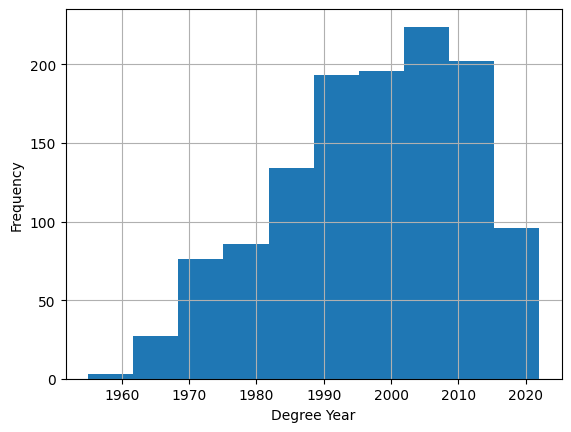

In [14]:
aarc_nf.persons["DegreeYear"].hist()
plt.xlabel("Degree Year")
plt.ylabel("Frequency")

### Joining
More complicated analysis require re-joining the separate tables back together.
For instance, to show the number of departments per umbrella, we need the umbrella names from `aarc_nf.umbrellas`.

In [15]:
aarc_nf.department_taxonomies\
    .join(
        aarc_nf.umbrellas,
        on="UmbrellaId", # the foreign key in `department_taxonomies`
        how="left", # left join keeps all rows from `department_taxonomies`
        )\
    .groupby([
        "UmbrellaId", # in case of duplicate umbrella names
        "Umbrella"])\
    ["DepartmentId"]\
    .nunique()\
    .sort_values()

UmbrellaId  Umbrella                 
3           Mathematics and Computing    2
7           Education                    3
4           Engineering                  5
5           Social Sciences              5
6           Applied Sciences             5
0           Natural Sciences             7
1           Medicine and Health          8
2           Humanities                   9
Name: DepartmentId, dtype: int64

Let's compute the annual department sizes per gender as another example.

In [16]:
aarc_nf.appointments\
    .join(aarc_nf.persons["Gender"],
          on="PersonId")\
    .groupby(["DepartmentId", "Gender", "Year"])\
    .size()\
    .sort_index()

DepartmentId  Gender   Year
835           Female   2011    2
                       2012    2
                       2013    2
                       2014    2
                       2015    3
                              ..
14156         Male     2014    8
              Unknown  2011    3
                       2012    2
                       2013    2
                       2014    2
Length: 1013, dtype: int64

## Advanced topics

### Databases

Databases are often used when datasets are too big to be stored in local memory or when many people need to work on the same dataset.
All concepts naturally translate to databases (in fact it's what normalization was developed for initially).
The most common databases for relational data are based on the SQL-language.
Everything presented here naturally translates to these databases, where each `DataFrame` is represented as its own table.

In [17]:
# Connect to a temporary SQLite database:
with sqlite3.connect(FOLDER_DB) as conn:
    # Creates tables based on the persons and appointments DataFrames:
    aarc_nf.persons.to_sql(
        "persons",
        conn,
        if_exists="replace",
        index=True,
    )
    aarc_nf.appointments.to_sql(
        "appointments",
        conn,
        if_exists="replace",
        index=True,
    )

    # Get number of faculty members broken down by gender, department, and year:
    res = conn.execute("""
        SELECT
            p.gender,
            a.departmentid,
            a.year,
            COUNT(DISTINCT p.personid) AS count
        FROM appointments AS a
        JOIN persons AS p
        ON a.personid = p.personid
        GROUP BY
            a.departmentid,
            a.year"""
    ).fetchall() # Get all results
res

[('Male', 835, 2011, 10),
 ('Male', 835, 2012, 10),
 ('Male', 835, 2013, 10),
 ('Male', 835, 2014, 10),
 ('Female', 835, 2015, 12),
 ('Female', 835, 2016, 11),
 ('Female', 835, 2017, 10),
 ('Female', 835, 2018, 9),
 ('Female', 835, 2019, 8),
 ('Female', 835, 2020, 8),
 ('Female', 835, 2021, 8),
 ('Female', 835, 2022, 8),
 ('Female', 835, 2023, 8),
 ('Male', 1289, 2015, 7),
 ('Male', 1289, 2016, 6),
 ('Male', 1289, 2017, 6),
 ('Male', 1289, 2018, 6),
 ('Male', 1289, 2019, 6),
 ('Male', 1289, 2020, 6),
 ('Male', 1289, 2021, 6),
 ('Male', 1504, 2011, 17),
 ('Male', 1504, 2012, 15),
 ('Male', 1504, 2013, 12),
 ('Male', 1504, 2014, 12),
 ('Male', 1504, 2015, 11),
 ('Male', 1504, 2016, 11),
 ('Male', 1791, 2011, 9),
 ('Male', 1791, 2012, 9),
 ('Male', 1791, 2013, 9),
 ('Male', 1791, 2014, 9),
 ('Male', 1791, 2015, 10),
 ('Male', 1791, 2016, 8),
 ('Male', 1791, 2017, 8),
 ('Male', 1791, 2018, 8),
 ('Male', 1791, 2019, 8),
 ('Male', 1791, 2020, 8),
 ('Male', 1791, 2021, 7),
 ('Male', 1791, 202

### Other normal forms

#### 1. Normal Form (1NF)
- each cell consists of **atomic** elements only
  - no collections of values are allowed
- the `AARC-v3` dataset already follows this normal form
- let's consider an artificial counter example

In [18]:
unf = pd.DataFrame(
    data={
        "DepartmentId": [1, 2, 3],
        "Year": [2020, 2021, 2022],
        "DepartmentName": ["A", "B", "C"],
        "PersonId": [[1,2], [3,4,5], [10]],
        "PrestigeRank": [.1, .1, .2],
        "DepartmentHead": ["Bob", "Alice", "Charlie"],
        "DepartmentHeadGender": ["M", "W", "M"],
    }
)
unf

,DepartmentId,Year,DepartmentName,PersonId,PrestigeRank,DepartmentHead,DepartmentHeadGender
0,1,2020,A,"[1, 2]",0.1,Bob,M
1,2,2021,B,"[3, 4, 5]",0.1,Alice,W
2,3,2022,C,[10],0.2,Charlie,M


This can be transformed to 1NF by 
- **exploding** the `PersonId` column (the name of the functions matches its implications)

In [19]:
aarc_toy = unf.explode("PersonId")
aarc_toy

,DepartmentId,Year,DepartmentName,PersonId,PrestigeRank,DepartmentHead,DepartmentHeadGender
0,1,2020,A,1,0.1,Bob,M
0,1,2020,A,2,0.1,Bob,M
1,2,2021,B,3,0.1,Alice,W
1,2,2021,B,4,0.1,Alice,W
1,2,2021,B,5,0.1,Alice,W
2,3,2022,C,10,0.2,Charlie,M


- this is the current state of the `AARC-v3` dataset!
  - note the redundancy in `DepartmentName` and the lack of identifiability
- better: separation into multiple tables
  - indexed by their **primary key**

In [20]:
aarc_toy_hiring = aarc_toy\
    [["DepartmentId", "PersonId", "Year", "PrestigeRank"]]\
    .drop_duplicates()\
    .set_index(["DepartmentId", "PersonId", "Year"])\
    .sort_index()
aarc_toy_hiring

PrestigeRank
DepartmentId PersonId Year              
1            1        2020           0.1
             2        2020           0.1
2            3        2021           0.1
             4        2021           0.1
             5        2021           0.1
3            10       2022           0.2

In [21]:
aarc_toy_dep = aarc_toy\
    [["DepartmentId", "DepartmentName", "DepartmentHead", "DepartmentHeadGender"]]\
    .drop_duplicates()\
    .set_index("DepartmentId")
aarc_toy_dep

,DepartmentName,DepartmentHead,DepartmentHeadGender
DepartmentId,,,
1,A,Bob,M
2,B,Alice,W
3,C,Charlie,M


#### 2. Normal Form (2NF)
- 2NF requires that all columns depend on the full **primary key**
- `aarc_toy`, `aarc_toy_hiring` and the full sample `aarc_sample_raw` all violate this requirement
  - for instance, `PrestigeRank` in `aarc_toy_hiring` depends only on `DepartmentId` and `Year`, but not on `PersonId`
  - there are many more examples in the full sample
    - `DepartmentName` depends only on `DepartmentId` not on the other key parts (`PersonId`, `Year`, `InstitutionId`, ...)

In [22]:
aarc_toy[["DepartmentId", "PersonId", "Year"]].drop_duplicates()

,DepartmentId,PersonId,Year
0,1,1,2020
0,1,2,2020
1,2,3,2021
1,2,4,2021
1,2,5,2021
2,3,10,2022


In [23]:
aarc_toy[["DepartmentId", "Year", "PrestigeRank"]].drop_duplicates().set_index(
    ["DepartmentId", "Year"]
).sort_index()

,,PrestigeRank
DepartmentId,Year,
1,2020,0.1
2,2021,0.1
3,2022,0.2


#### 3. Normal Form (3NF)
- 3NF requires that there are no transitive dependencies
- in our toy example, `aarc_toy_dep` still violates this because `DepartmentHeadGender` depends on `DepartmentHead` which depends on `DepartmentId`

In [24]:
aarc_toy_dep.reset_index()[["DepartmentHead", "DepartmentHeadGender"]].drop_duplicates()

,DepartmentHead,DepartmentHeadGender
0,Bob,M
1,Alice,W
2,Charlie,M


In [25]:
aarc_toy_dep[["DepartmentHead", "DepartmentName"]].drop_duplicates()

,DepartmentHead,DepartmentName
DepartmentId,,
1,Bob,A
2,Alice,B
3,Charlie,C


- we created four separate tables, each representing a unique entity or relationship
- there is no redundant data and each entity/relationship is identifiable